# Анализ результатов кластеризации

In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import SpectralClustering
from clust_functions import plot, get_size, silhouette_plot

import warnings
warnings.filterwarnings("ignore")

RAND = 10

In [6]:
# загрузка эмбеддингов после UMAP (3 измерения)
X_embedding = pd.read_pickle('X_embedding_3.pkl')
X_embedding.head()

,0,1,2
0,-3.099881,-2.076641,4.294221
1,-2.878557,-0.563933,3.511552
2,-0.888033,4.634923,-1.450897
3,4.990706,8.355982,-3.858088
4,8.829126,7.900076,-3.438453


In [7]:
# полный бинаризованный датасет
X = pd.read_csv('data_bin.csv')
X.head()

,name,total_crashes,total_runs,year,nov22,dec22,jan23,feb23,mar23,apr23,...,category_Radiation,category_Roughness,category_StartStopSaveLoad,category_Subregions,category_Substances,category_Turbulence,category_UserFunction,category_VerificationTests,category_Vizu,category_tutorial
0,06_Plate2D_45_turb,25,2398,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,08_NACA0012_a8_M03,25,2319,2014,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0_diam_0_particles,22,1959,2015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0_diam_0_particles2,14,1534,2017,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0_surface_supergroup,3,1272,2018,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


На данном этапе проанализируем полученные кластеры в разрезе слабых моментов базы автотестирования (см. раздел EDA).
- Как связаны кластера и категория (название тестируемого функционала)?
- Какие тесты необходимо актуализировать?
- Какие тесты подозрительно редко срабатывают? 
- Какие тесты самые затратные по вычислительным ресурсам?

## Выбранная модель - Spectral clustering

In [10]:
# задаём модель с наилучшими гиперпараметрами
sp_clust = SpectralClustering(n_clusters=40, assign_labels = 'discretize', eigen_solver=None, affinity='rbf')
sp_clust.fit(X_embedding)

SpectralClustering(assign_labels='discretize', n_clusters=40)

In [15]:
sp_labels = sp_clust.labels_ + 1

### Размер кластеров 

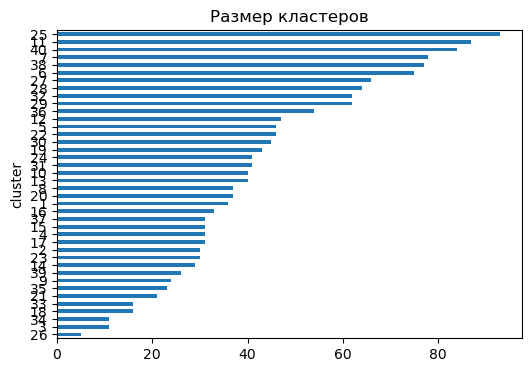

In [16]:
get_size(X_embedding, sp_labels )

In [18]:
X_clust = X.assign(cluster=sp_labels)
cluster_size = X_clust.groupby('cluster').count().iloc[:, 0]

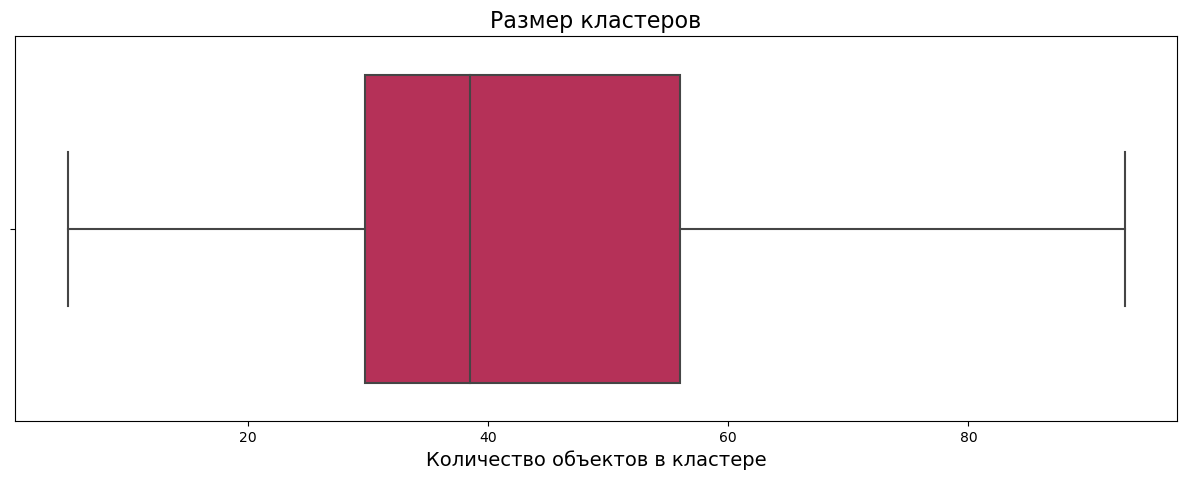

In [22]:
plt.figure(figsize=(15, 5))

sns.boxplot(cluster_size, palette='rocket')

plt.title('Размер кластеров', fontsize=16)
plt.xlabel('Количество объектов в кластере', fontsize=14)
plt.show()

<div class="alert alert-block alert-info">
По общей статистике, максимальное число элементов в кластере = 100, минимальное = 10. Однако, большая часть кластеров, заключённая в межквантильный диапазон, содержит от 30 до 60 объектов. Это цифры формируют подъёмную нагрузку на отдел QA для дополнительного анализа сходства между тестами внутри одного кластера.

</div>

###  Ключевые различия между кластерами

In [35]:
X_clust = X.assign(cluster=sp_labels)
cluster_size = X_clust.groupby('cluster').count().iloc[:, 0]

In [40]:
# среднее значение признаков для каждого кластера
mean_per_clust = X_clust.groupby('cluster').mean().T 
mean_per_clust

cluster,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
total_crashes,16.805556,59.300000,10.636364,22.516129,463.456522,23.293333,12.307692,19.351351,68.458333,112.000,...,1128.682927,25.774194,37.8750,21.818182,57.043478,36.685185,66.935484,74.064935,19.115385,29.714286
total_runs,862.972222,425.566667,2289.636364,1029.516129,2188.869565,1746.040000,408.089744,1674.648649,2368.958333,1140.350,...,2207.170732,1463.354839,217.1250,1900.818182,112.913043,745.981481,1571.000000,2013.727273,2330.269231,2318.392857
year,2019.972222,2018.066667,2014.000000,2019.000000,2014.195652,2015.893333,2021.333333,2016.027027,2014.000000,2016.550,...,2014.000000,2017.290323,2016.8750,2015.090909,2016.260870,2020.111111,2016.870968,2014.974026,2014.000000,2014.000000
nov22,0.027778,0.000000,0.000000,0.000000,0.021739,0.000000,0.641026,0.000000,0.041667,0.025,...,0.000000,0.129032,0.1875,0.181818,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
dec22,0.000000,0.233333,0.000000,0.000000,0.086957,0.053333,0.153846,0.000000,0.041667,0.025,...,0.073171,0.145161,0.3750,0.000000,0.000000,0.259259,0.258065,0.000000,0.038462,0.059524
jan23,0.083333,0.000000,0.000000,0.000000,0.021739,0.000000,0.089744,0.000000,0.041667,0.025,...,0.024390,0.129032,0.1250,0.181818,0.000000,0.185185,0.000000,0.012987,0.038462,0.011905
feb23,1.138889,0.100000,0.000000,1.000000,0.934783,0.960000,0.846154,1.000000,1.000000,0.800,...,0.902439,0.903226,0.3125,1.181818,0.000000,1.462963,1.000000,0.922078,0.884615,1.023810
mar23,0.305556,0.066667,0.000000,0.032258,0.326087,0.026667,0.371795,0.000000,0.041667,0.175,...,0.048780,0.048387,0.4375,0.000000,0.000000,0.111111,0.258065,0.000000,0.038462,0.000000
apr23,0.111111,0.000000,0.000000,0.225806,0.021739,0.053333,0.166667,0.000000,0.083333,0.075,...,0.000000,0.032258,0.1250,0.000000,0.000000,0.370370,0.000000,0.012987,0.038462,0.011905
may23,0.111111,0.000000,0.000000,0.064516,0.021739,0.053333,0.307692,0.135135,0.041667,0.200,...,0.048780,0.096774,0.1875,0.818182,0.000000,0.796296,0.258065,0.025974,0.076923,0.011905


<div class="alert alert-block alert-info">

В таблице выше представлены среднее значение признака для каждого кластера. По сути это расшифровка принципа группировки модели. отдельно рассмотрим отличия между кластерами для признаков:

- category - для поиска взаимосвязи между разбиением на кластеры и категорией тестируемого функционала
- last_run_days и year - для поиска взаимосвязи между разбиением и возрастом тестов
- last_crash_days - для поиска экстремальных сущностей, которые потенциально не отлавливают ошибки
- total_crashes - для определения кластеров, содержащих частопадающие тесты. Там проблема в тесте? Или в функционале?
- seconds_total - для определения кластеров, содержащих наиболее затратные тесты   

</div>

####  Топ категории для каждого кластера

Отобразим названия функционала (категорию теста), которые оказали наибольшее влияние на разбиение по кластерам.

In [84]:
# датасет с бинаризованными данными (категория функционала)
category_bin = mean_per_clust.iloc[-29:, :]
#category_bin

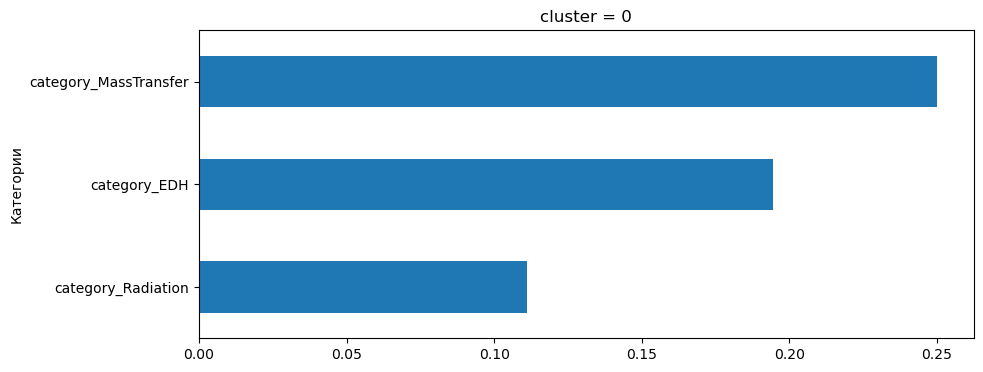

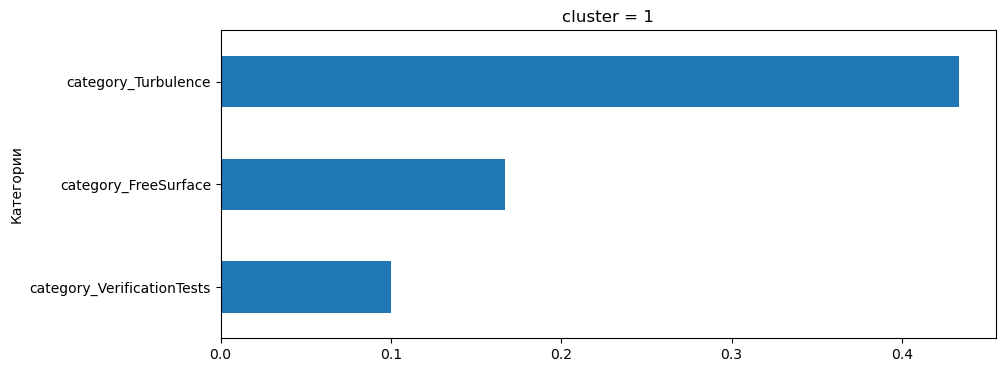

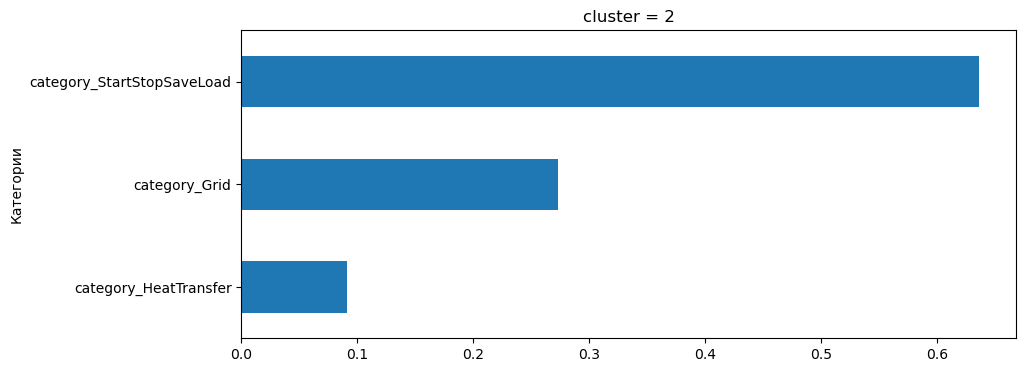

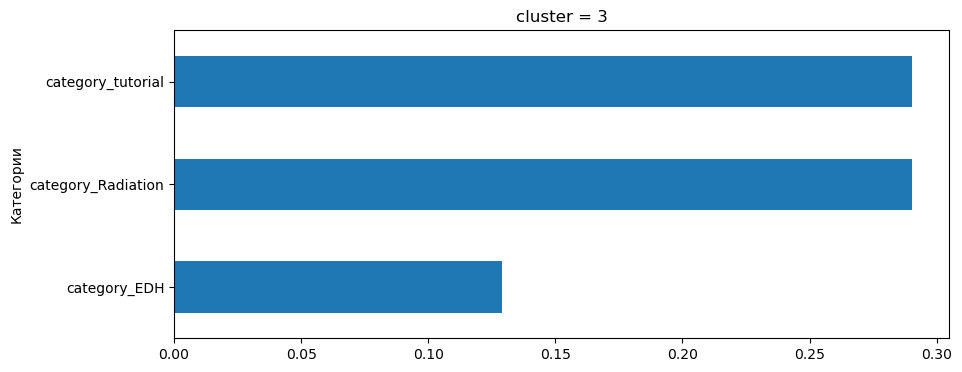

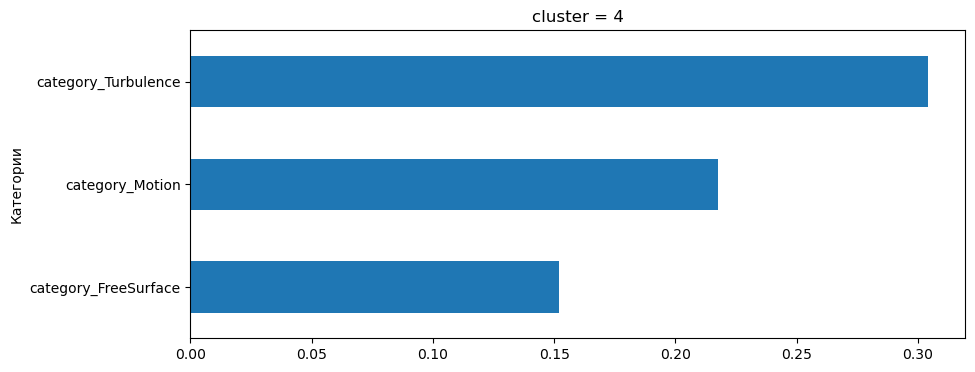

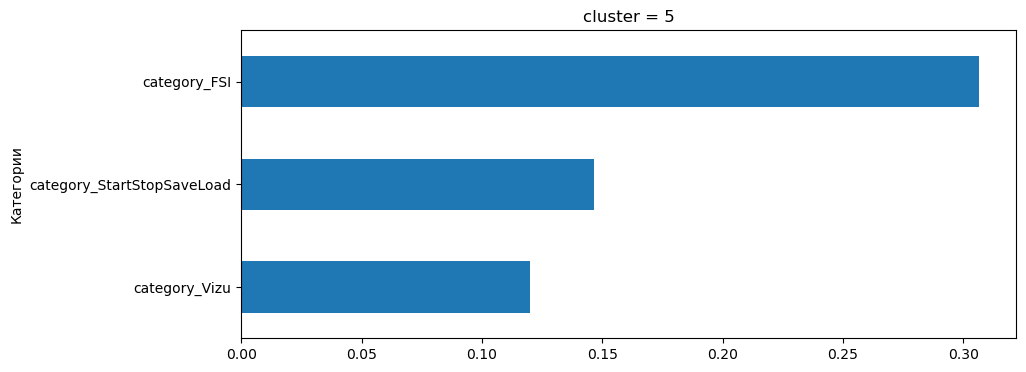

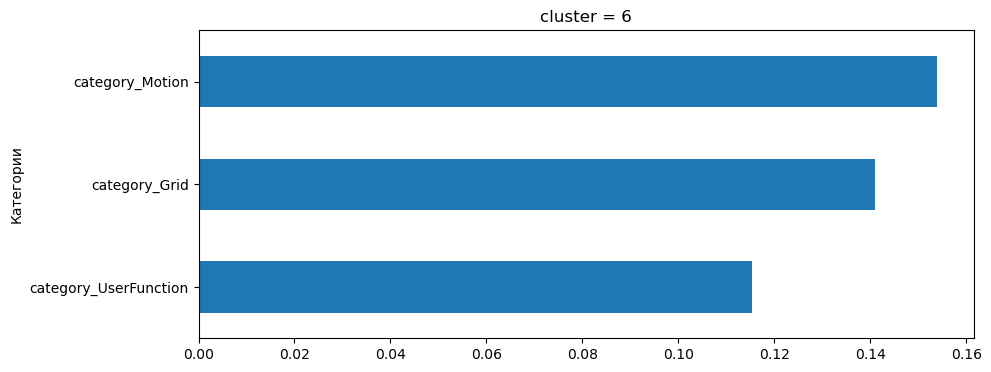

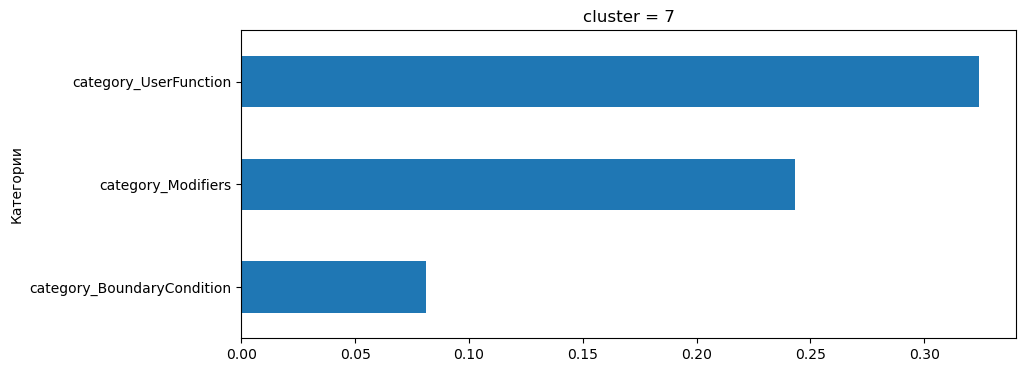

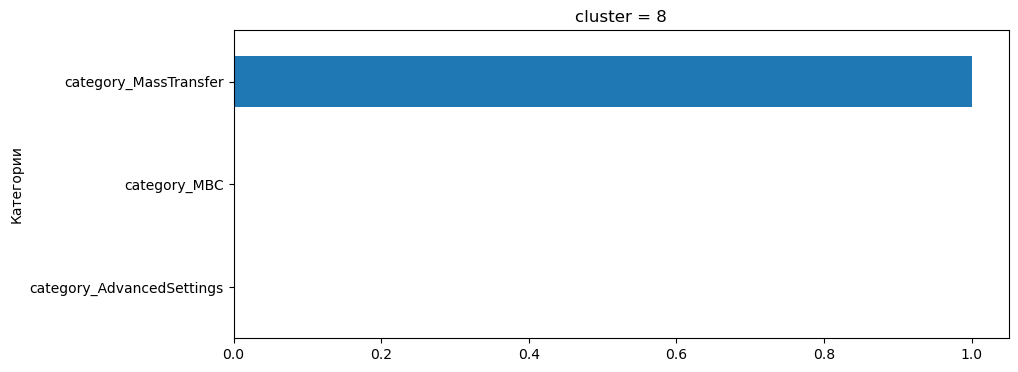

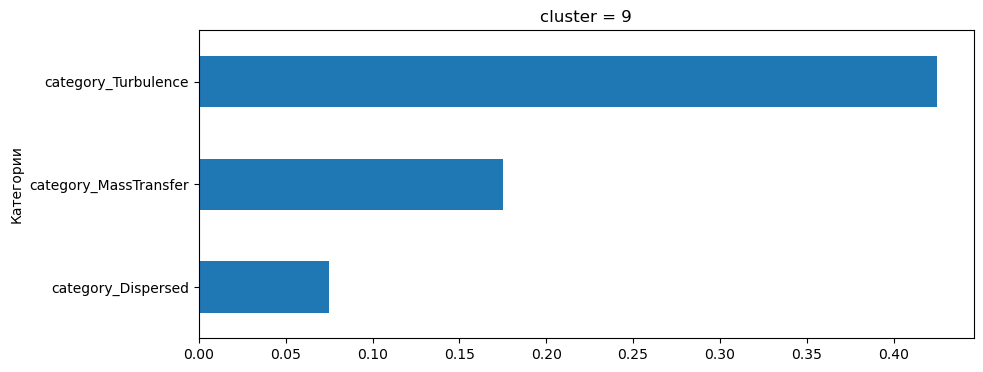

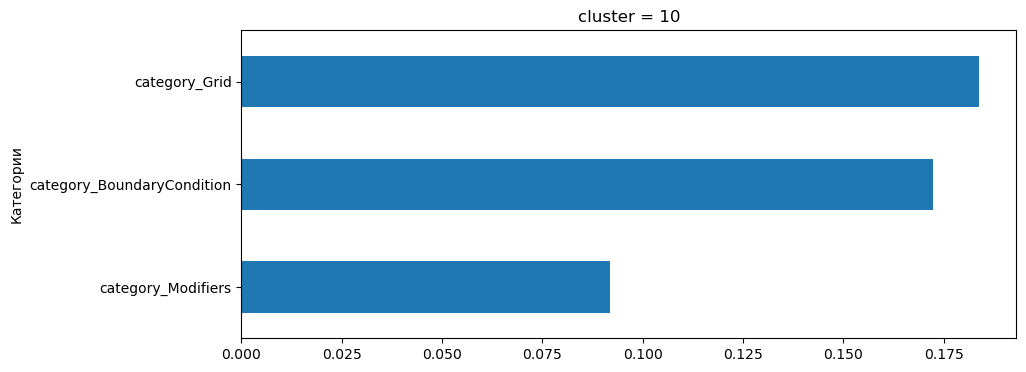

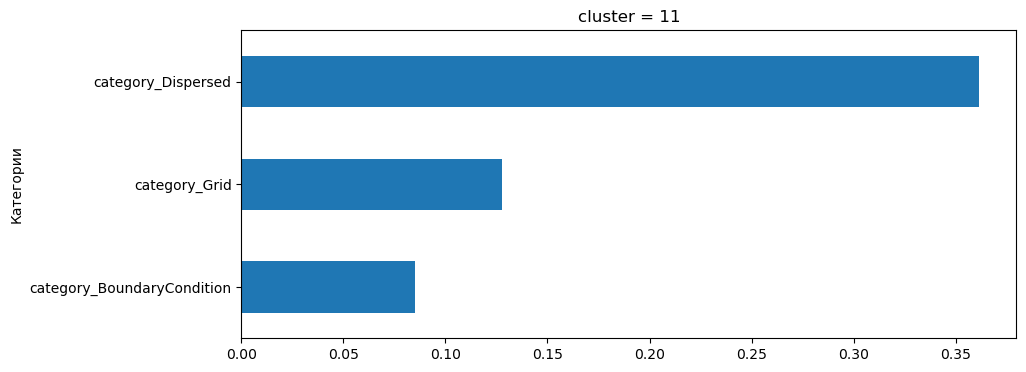

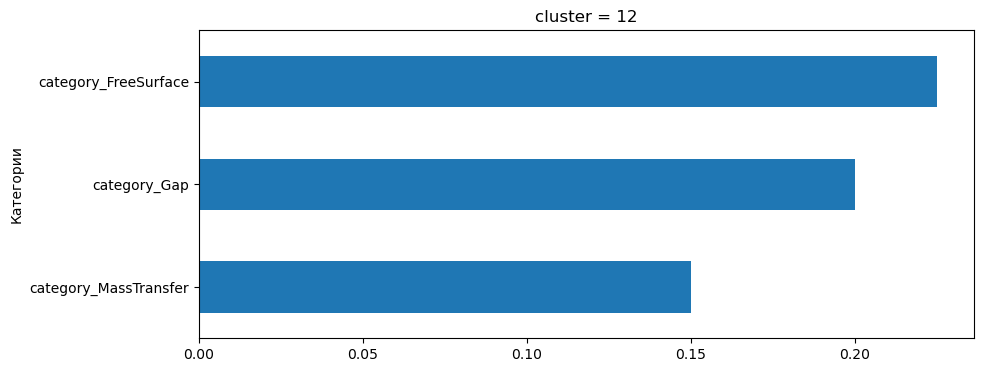

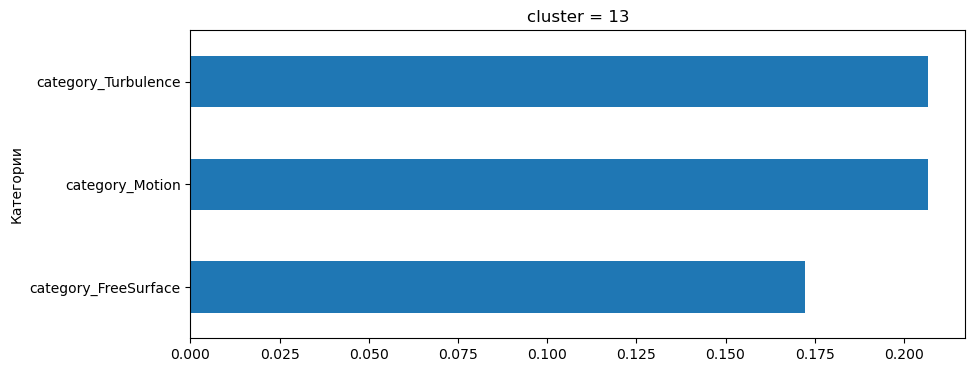

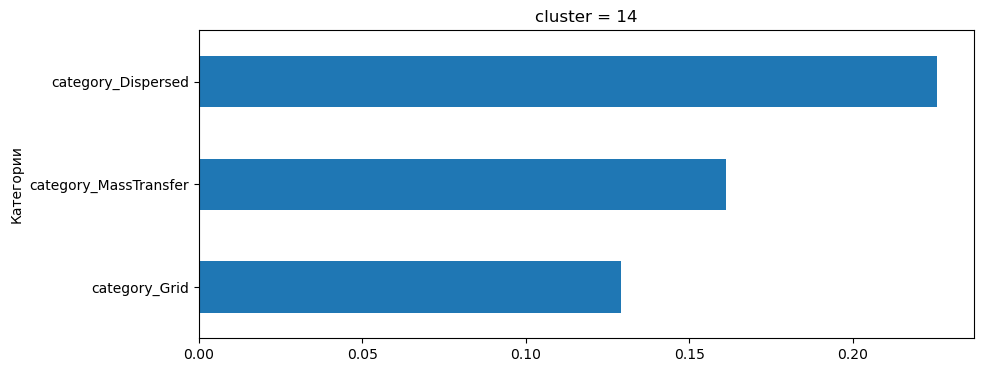

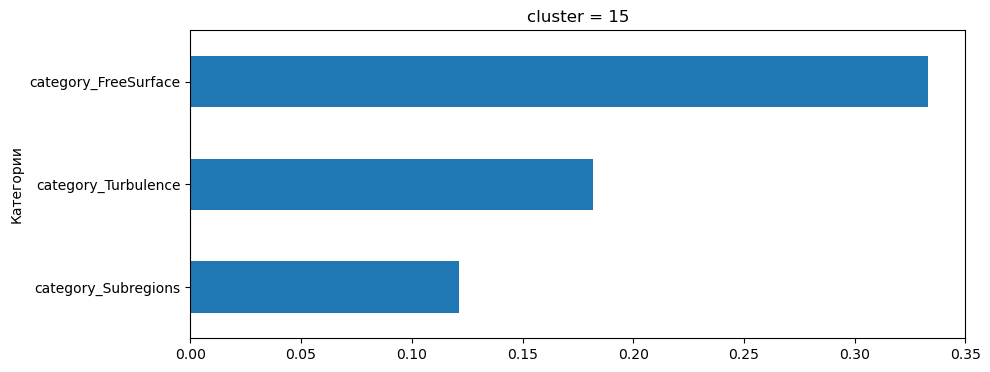

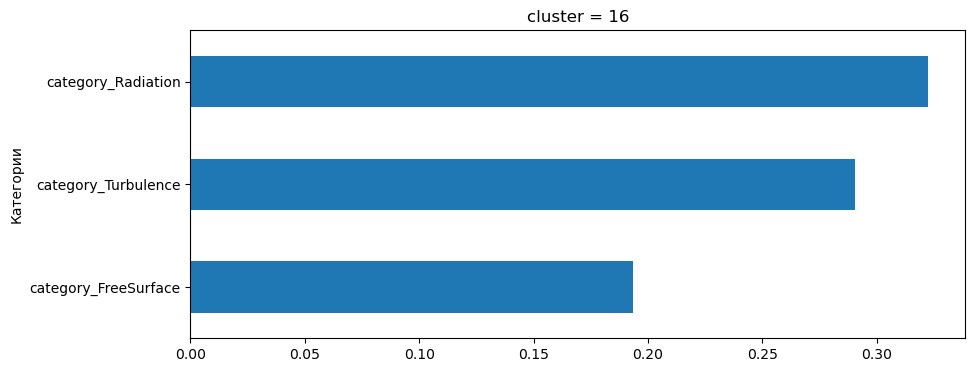

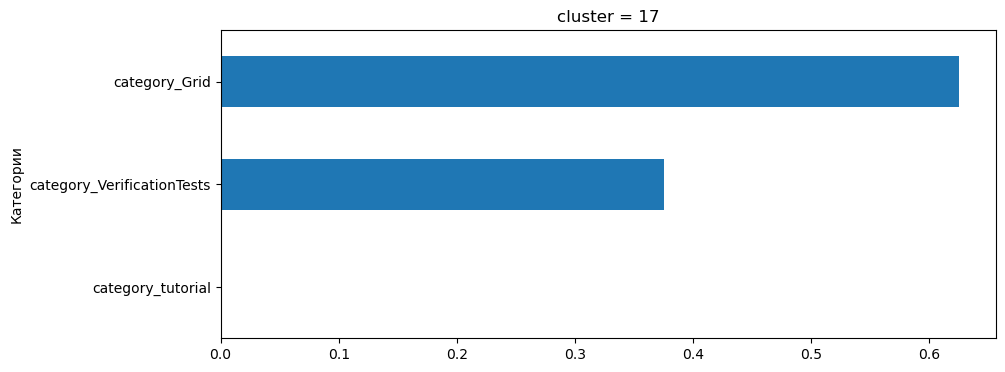

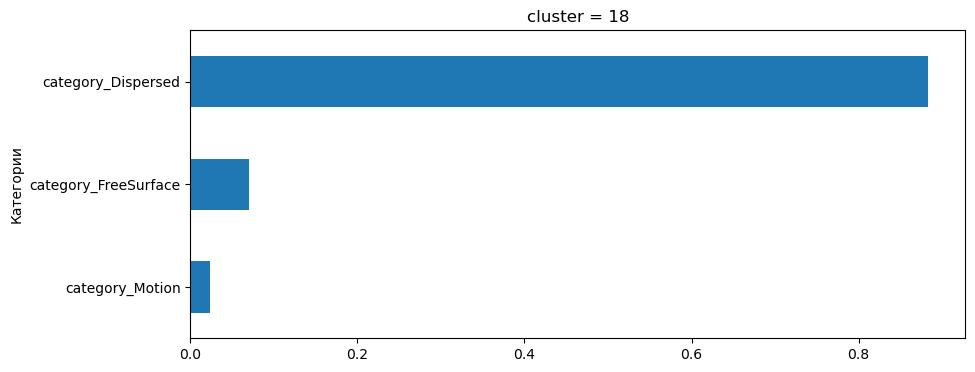

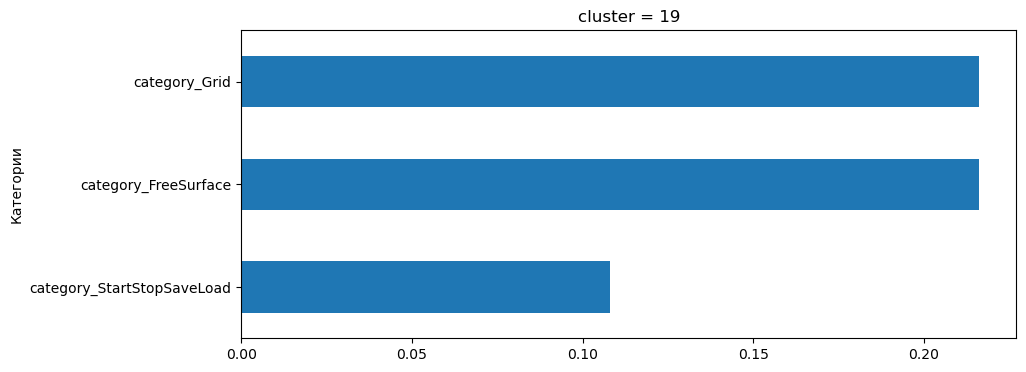

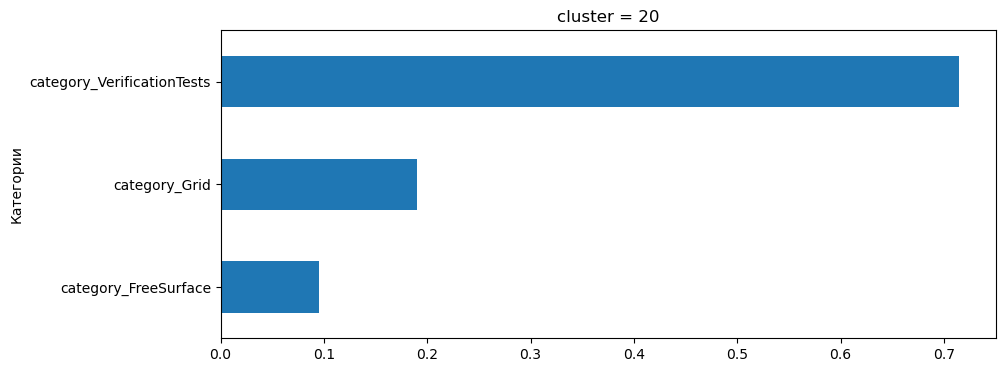

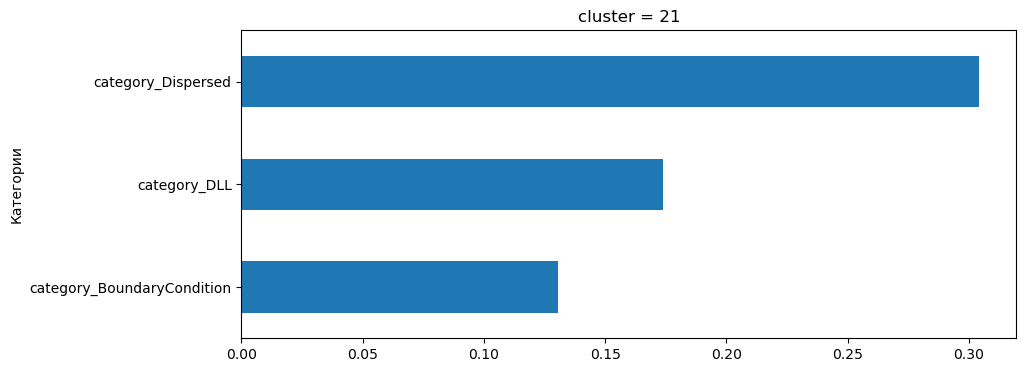

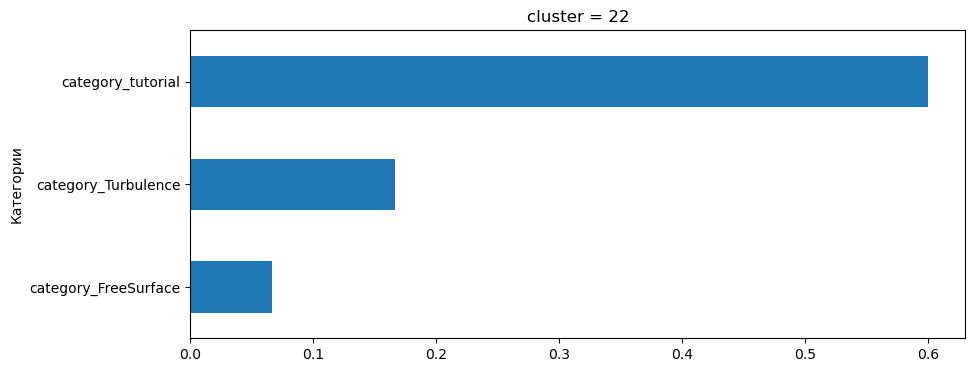

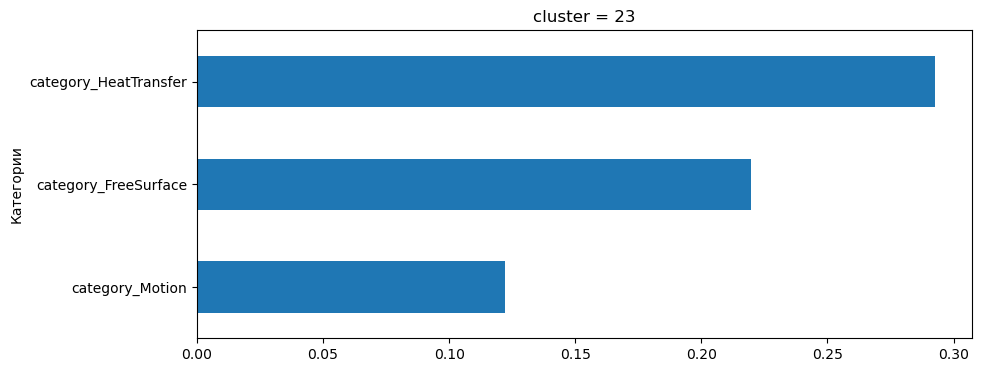

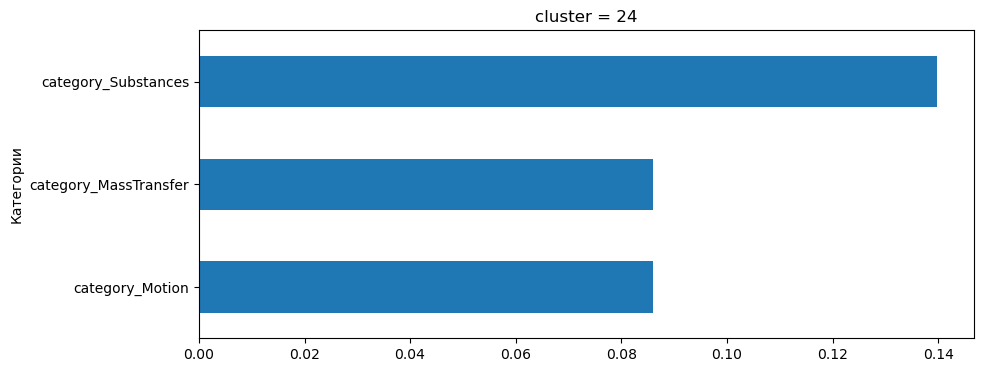

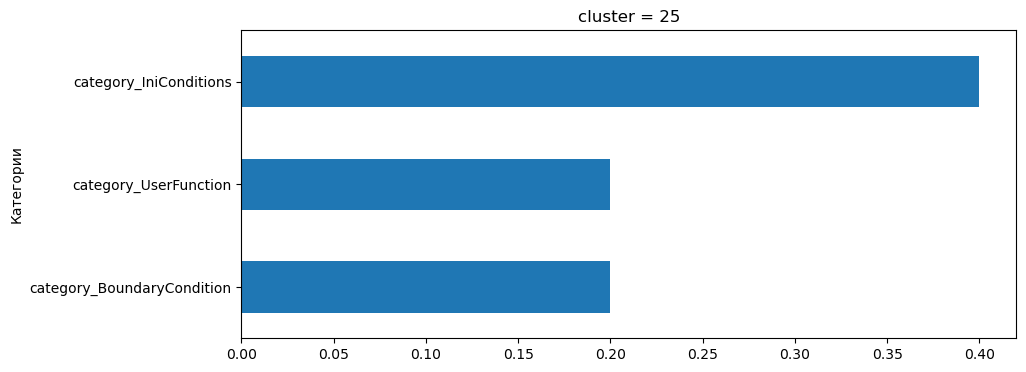

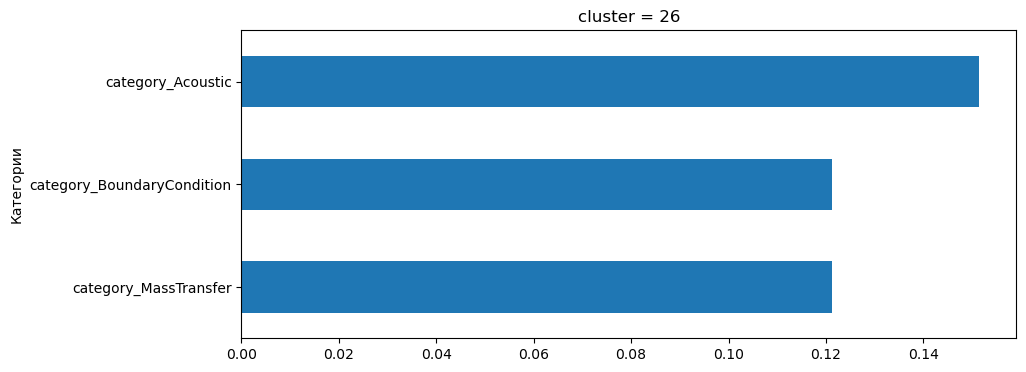

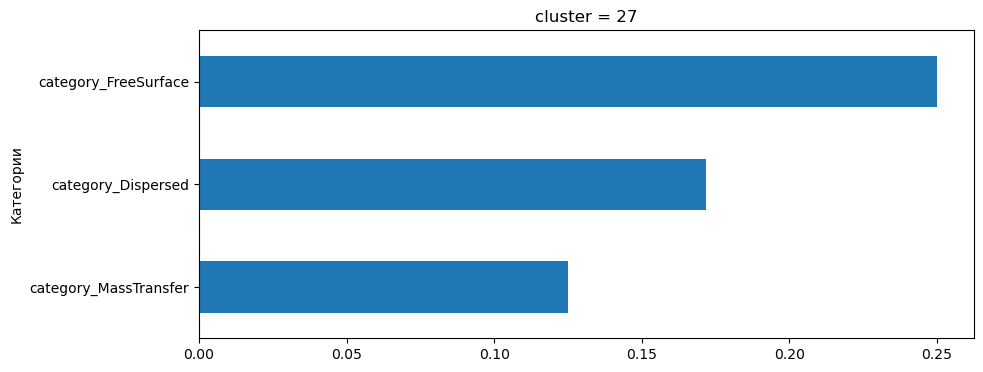

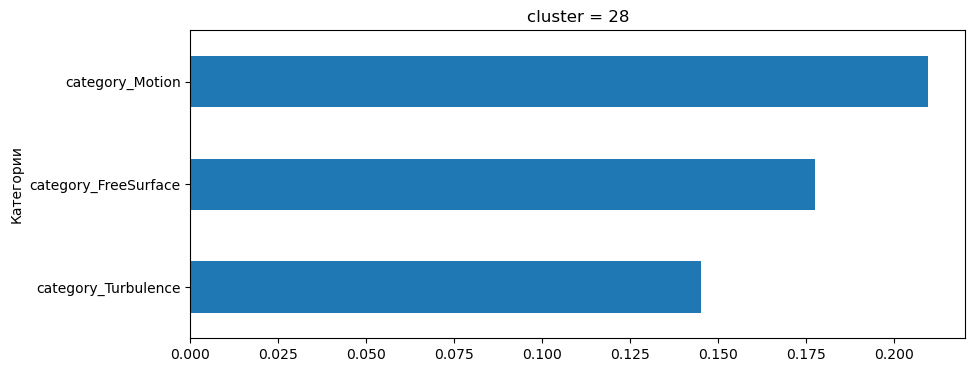

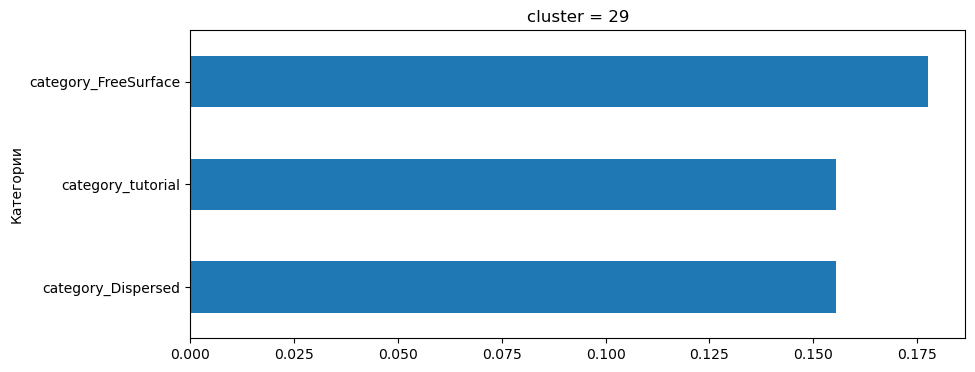

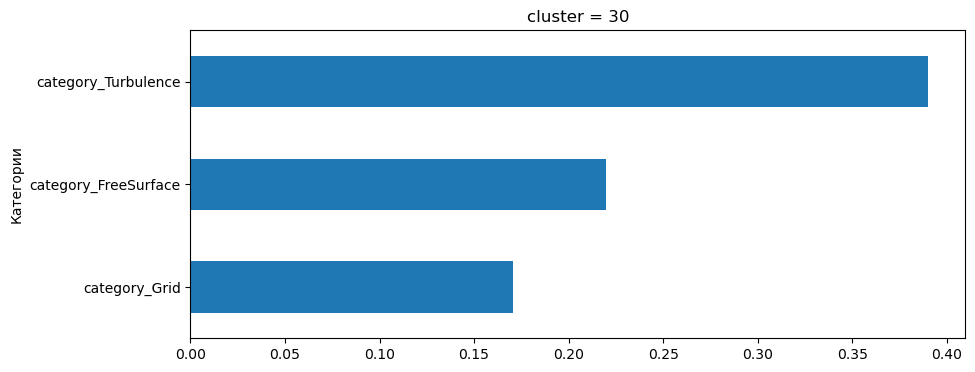

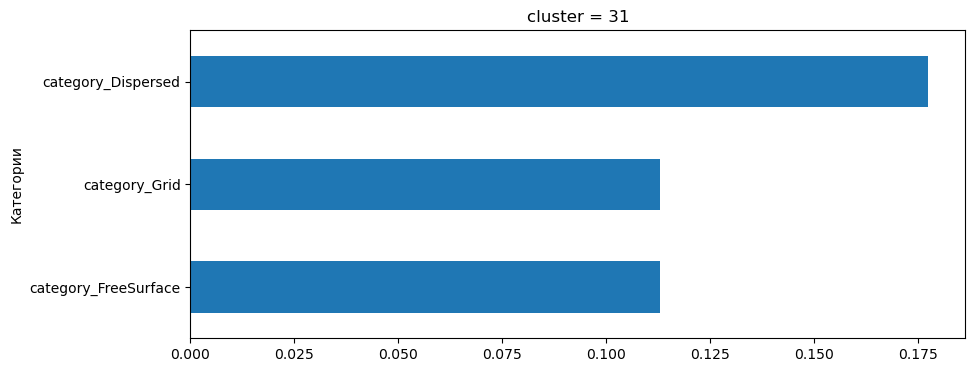

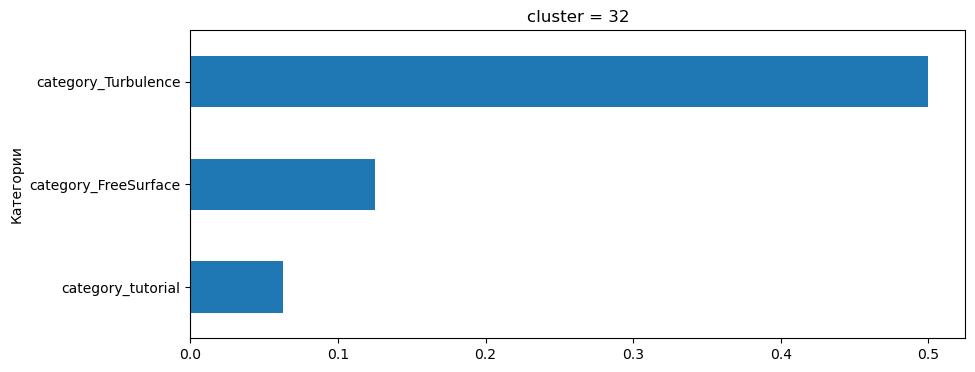

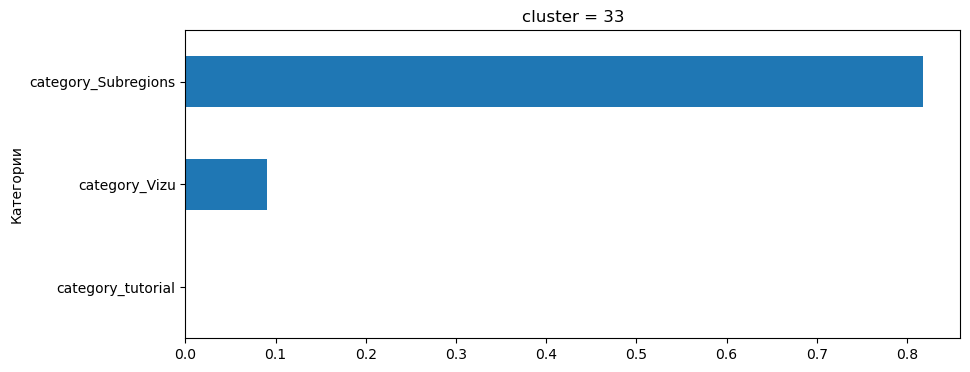

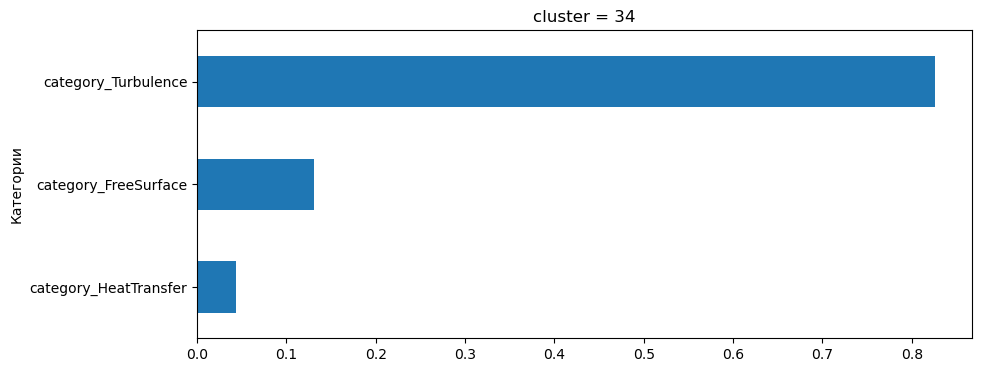

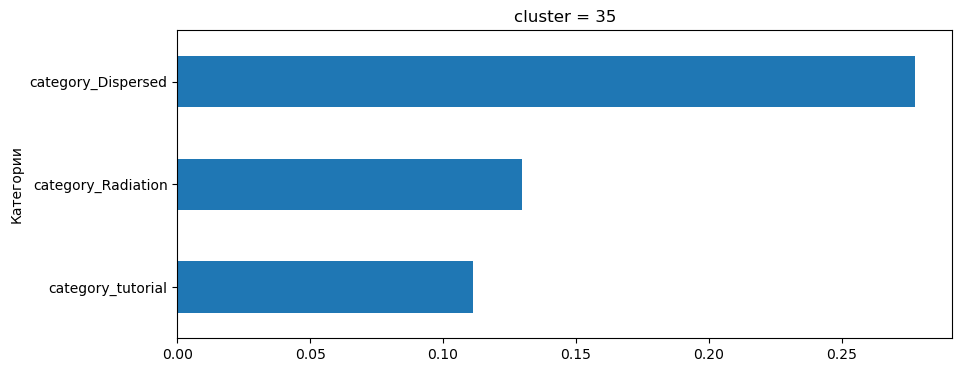

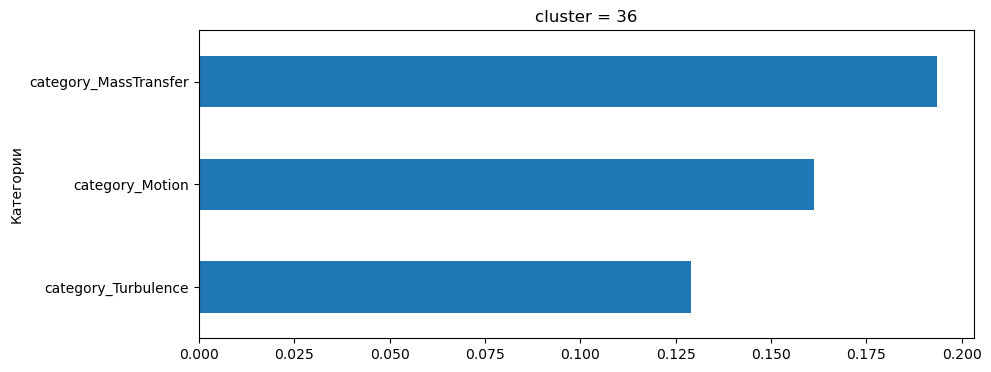

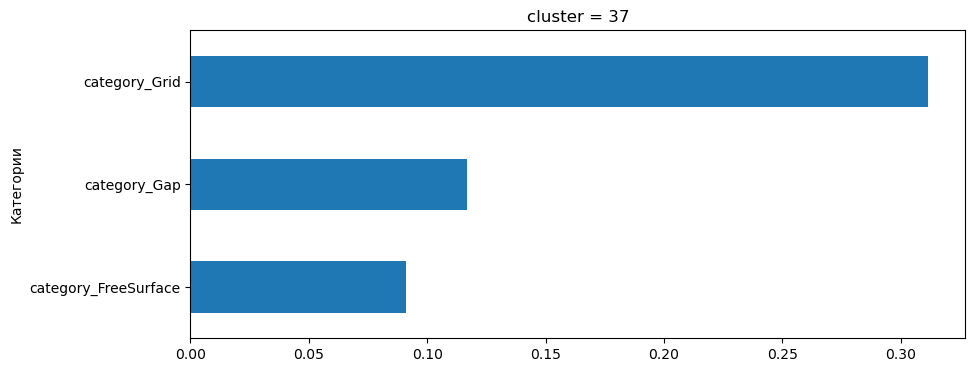

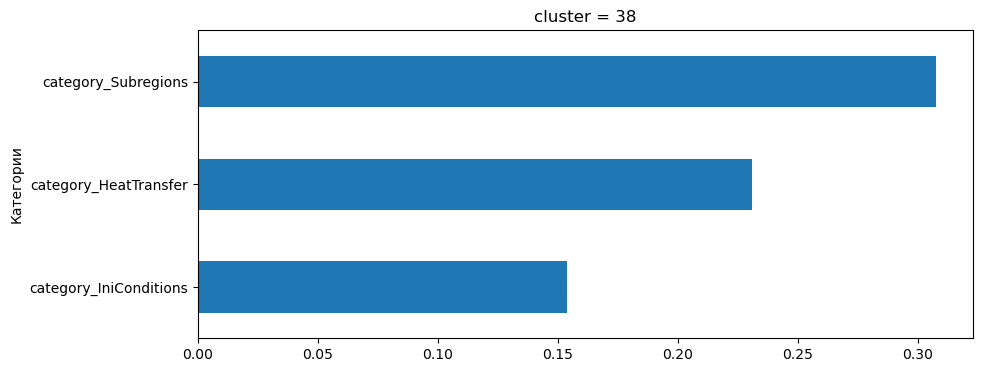

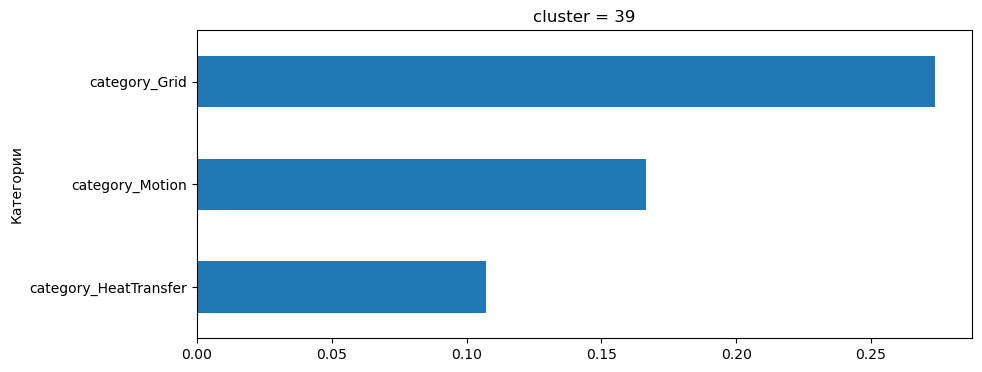

In [83]:
n_clusters = 40

# Топ категории для каждого кластера
for i in range(n_clusters):
    plt.figure(figsize=(10,4))
    plt.ylabel("Категории")
    plt.title('cluster = ' + str(i))
    category_bin.iloc[:, i].sort_values()[-3:].plot.barh(color='C0')

    plt.show()

####  Распределение кластеров по категориям

Другой взгляд на взаимосвязь кластеров и категорий. Посмотрим как кластеры распределены внутри каждой категории функционала. 

In [118]:
top_list = []
for i in range(n_clusters):
    top_list.append(category_bin.iloc[:, i].sort_values()[-3:])
top = pd.DataFrame(top_list)

top

,category_Radiation,category_EDH,category_MassTransfer,category_VerificationTests,category_FreeSurface,category_Turbulence,category_HeatTransfer,category_Grid,category_StartStopSaveLoad,category_tutorial,...,category_Modifiers,category_AdvancedSettings,category_MBC,category_Dispersed,category_Gap,category_Subregions,category_DLL,category_Substances,category_IniConditions,category_Acoustic
1,0.111111,0.194444,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.100000,0.166667,0.433333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,0.272727,0.636364,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.290323,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.290323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,0.152174,0.304348,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.146667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.141026,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.243243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,0.175000,NaN,NaN,0.425000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.075000,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">

Если первый набор графиков можно рассматривать как описание самих кластеров (обычно на каждый кластер приходится отдельная категория функционала. В этом их главное отличие), то таблица позволяет увидеть взаимосвязь между кластерами в контексте категории.

Например, в категории Radiation задействованы кластеры с номерами 1, 4, 17 и 36. Причём в кластерах 4 и 17 вес этой категории превалирует. Это означает, что при возникновении проблем с этим функционалом, в первую очередь необходимо смотреть тесты в кластерах 17, 4, 36 и 1 (по мере убывания веса).
</div>


#### Оценка тестов, требующих актуализации

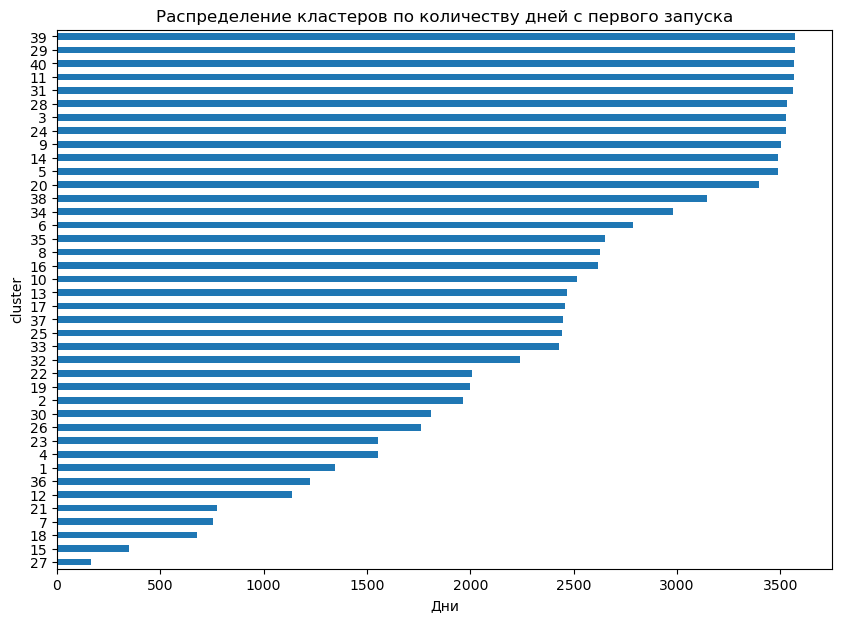

In [138]:
plt.figure(figsize=(10,7))
plt.title('Распределение кластеров по количеству дней с первого запуска')
mean_per_clust.iloc[16,:].sort_values().plot.barh(color='C0')
plt.xlabel("Дни")
plt.show()

In [115]:
mean_per_clust.iloc[2,:].sort_values()

cluster
20    2014.000000
31    2014.000000
29    2014.000000
28    2014.000000
24    2014.000000
39    2014.000000
11    2014.000000
9     2014.000000
40    2014.000000
3     2014.000000
14    2014.137931
5     2014.195652
38    2014.974026
34    2015.090909
6     2015.893333
8     2016.027027
16    2016.242424
35    2016.260870
10    2016.550000
17    2016.838710
13    2016.850000
37    2016.870968
33    2016.875000
25    2017.000000
32    2017.290323
22    2018.000000
19    2018.023256
2     2018.066667
30    2018.533333
26    2019.000000
4     2019.000000
23    2019.000000
1     2019.972222
36    2020.111111
12    2020.340426
21    2021.285714
7     2021.333333
18    2021.625000
15    2022.516129
27    2023.000000
Name: year, dtype: float64

<div class="alert alert-block alert-info">

По количеству дней с первого запуска лидируют тесты, объединеённые в кластеры под номерами 39, 29, 40, 11, 31, 28. Соответственно, эти тесты требуют больше внимания с точки зрения пересмотра их состава и актуализации под новую версию ПО.
    
Таблица с распределением кластеров по году добавления подтверждает выдвинутую гипотезу: наиболее ранние тесты принадлежат кластерам с номерами 20, 31, 29, 28, 39.
    
</div>

#### Оценка тестов с экстремальным числом падений

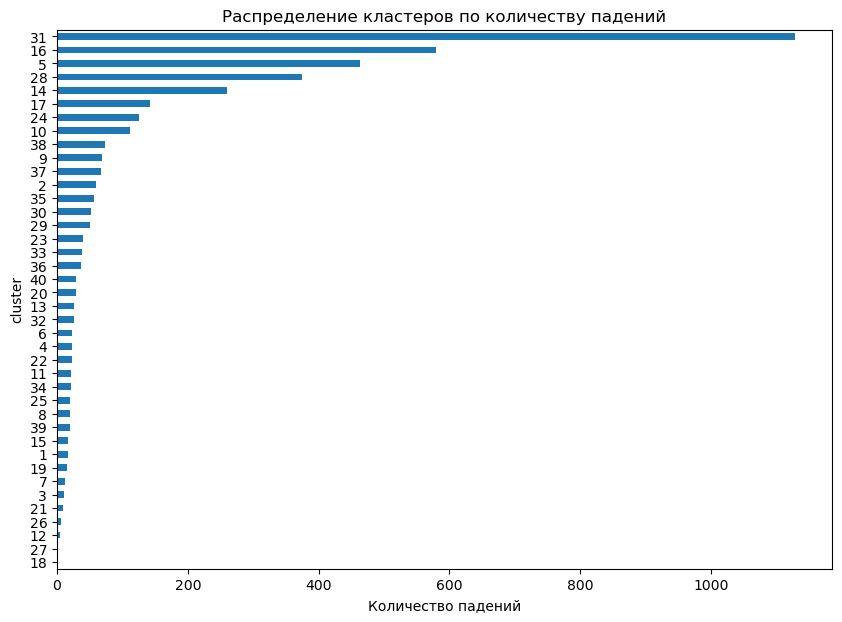

In [135]:
plt.figure(figsize=(10,7))
plt.title('Распределение кластеров по количеству падений')
mean_per_clust.iloc[0,:].sort_values().plot.barh(color='C0')
plt.xlabel("Количество падений")
plt.show()

<div class="alert alert-block alert-info">

Тесты в кластерах 31, 16, 5, 28, 14 самые проблемные, так как падают чаще всего. Необходимо их пересмотреть для выявления причин такого поведения. В тоже время, тесты в кластерах 27 и 18 не падают вообще. Желательно также посмотреть их состав и разобраться почему.
    
</div>

#### Оценка тестов по времени проигрывания 

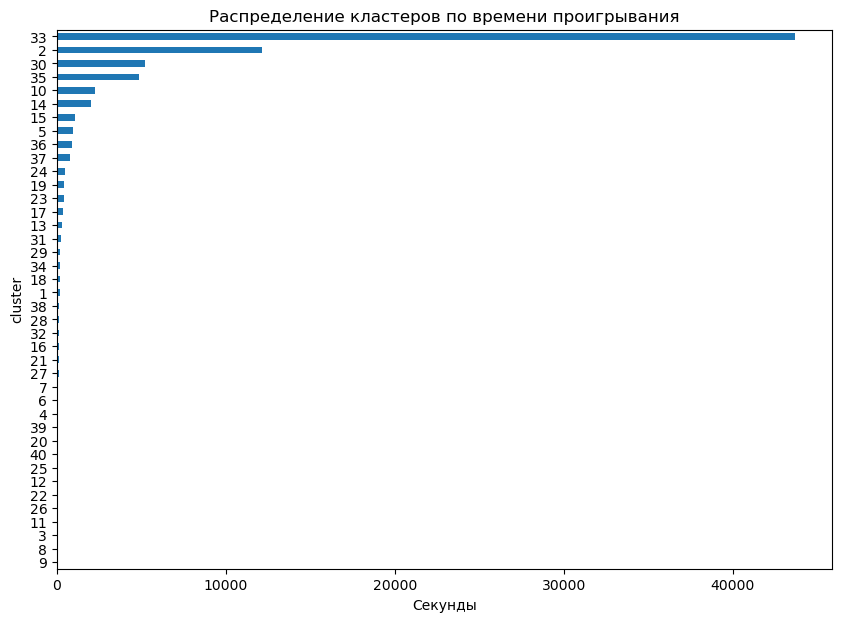

In [137]:
plt.figure(figsize=(10,7))
plt.title('Распределение кластеров по времени проигрывания')
mean_per_clust.iloc[15,:].sort_values().plot.barh(color='C0')
plt.xlabel("Секунды")
plt.show()


<div class="alert alert-block alert-info">

Тесты в кластере с номером 33 наиболее долгие, очень загружают вычислительные ресурсы. Необходимо их усовершенствовать, чтобы сократить время их счёта. Возможно от каких-то тестов отказаться в пользу оптимальной работы всей базы автотестов.
    
</div>

#### Оценка тестов по последнему дню падения

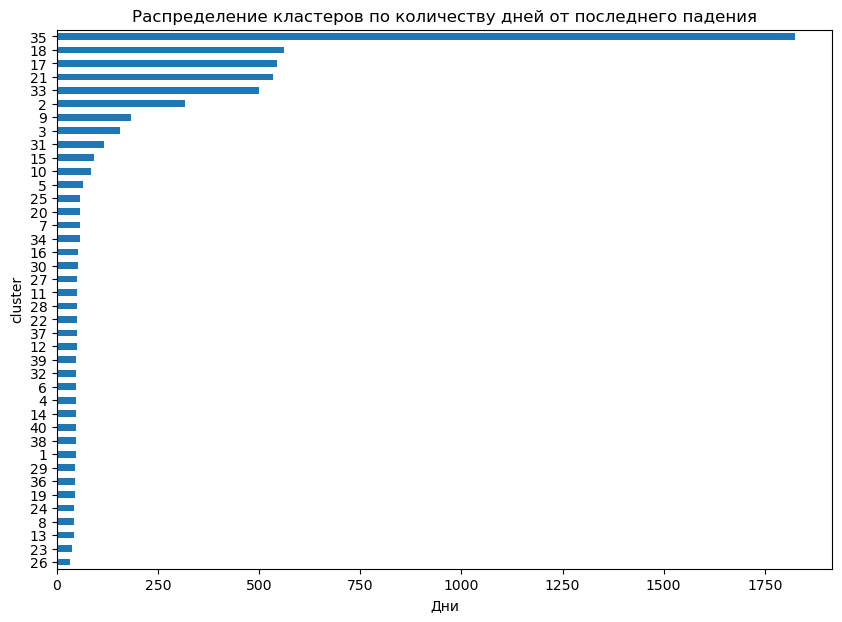

In [140]:
plt.figure(figsize=(10,7))
plt.title('Распределение кластеров по количеству дней от последнего падения')
mean_per_clust.iloc[17,:].sort_values().plot.barh(color='C0')
plt.xlabel("Дни")
plt.show()


<div class="alert alert-block alert-info">

Тесты в кластере с номером 35 выглядят наиболее подозрительно, так как давно не падали, и, следовательно, не отлавливали ошибок в программе. Другая группа кластеров, которая требует внимания - 18, 17, 21, 33. Все остальные тесты периодически срабатывают, что означает, что тест работоспособен.

    
</div>

### Итоговая таблица для работы отдела QA

Далее подготовим таблицу для передачи отделу QA c названием теста в базе и присвоенным номером кластера. По этой таблице можно определять взаимосвязи между тестами по результатам ML кластеризации.

In [117]:
res = X_clust[['name', 'cluster']]
res

,name,cluster
0,06_Plate2D_45_turb,11
1,08_NACA0012_a8_M03,40
2,0_diam_0_particles,38
3,0_diam_0_particles2,25
4,0_surface_supergroup,22
...,...,...
1695,Zeldonich_CH4_0_05,27
1696,Zeldonich_H2,27
1697,Zeldovich_CH4_without_temp,27
1698,zero_dens_after_adapt_dehn,12


## Выводы 

В итоговой версии алгоритма спектральной кластеризации было выделено 40 кластеров. 

При анализе кластеров по ключевым признакам определены:
- взаимосвязи отдельных кластеров и функционала программы
- кластера, содержащие требующие актуализации тесты
- кластера с подозрительно большим и малым числом падений
- кластера с наиболее ресурсозатратными тестами
- кластера с подозрительно длительным отсутствием падений

Таблица сопоставления имени теста и кластера поможет тестировщикам ориентироваться в сходести тестов. После получения отчёта о тестировании инженер проверит другие тесты из одного кластера и заранее улучшит качество базы автотестов. 